In [1]:
'''
Given folders of the full images from the human protein atlas, extract single cell crops.
To obtain single cell crops, an otsu filter is used to segment the nuclei channel, and then large enough connected
components in the nuclei channel are used as the centers for these crops.
Author: Alex Lu
Email: alexlu@cs.toronto.edu
Copyright (C) 2018 Alex Lu
'''

from PIL import Image
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os
from skimage.transform import resize
from skimage.filters import threshold_otsu
from skimage.filters import gaussian
from skimage.measure import label
from skimage.segmentation import clear_border
from skimage.morphology import remove_small_objects, remove_small_holes
from scipy.ndimage.measurements import center_of_mass
from glob import glob

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [7]:
def find_centers_and_crop(color_image, cropsize=128):
    '''
    Given an image, extract single cell crops:
    ARGUMENTS:
    color_image: shape, [4, 512, 512]
    '''
    # Split the image into channels
    red = color_image[0, :, :]
    green = color_image[1, :, :]
    blue = color_image[2, :, :]
    yellow = color_image[3, :, :]
    image_shape = color_image.shape[1:]

    # Segment the nuclear channel and get the nuclei
    min_green_size = 100.0

    val = threshold_otsu(green)
    smoothed_green = gaussian(green, sigma=5.0)
    binary_green = smoothed_green > val
    binary_green = remove_small_holes(binary_green, min_size=300)
    labeled_green = label(binary_green)
    labeled_green = clear_border(labeled_green)
    labeled_green = remove_small_objects(labeled_green, min_size=min_green_size)

    # Iterate through each nuclei and get their centers (if the object is valid), and save to directory
    output_images = []
    for i in range(1, np.max(labeled_green)):
        current_green = labeled_green == i
        #print(np.sum(current_green))
        if np.sum(current_green) > min_green_size:
            y, x = center_of_mass(current_green)
            x = np.int(x)
            y = np.int(y)

            c1 = y - cropsize // 2
            c2 = y + cropsize // 2
            c3 = x - cropsize // 2
            c4 = x + cropsize // 2

            if c1 < 0 or c3 < 0 or c2 > image_shape[0] or c4 > image_shape[1]:
                pass
            else:
                green_crop = green[c1:c2, c3:c4]
                red_crop = red[c1:c2, c3:c4]
                blue_crop = blue[c1:c2, c3:c4]
                yellow_crop = yellow[c1:c2, c3:c4]

                green_crop = np.expand_dims(green_crop, axis=0)
                red_crop = np.expand_dims(red_crop, axis=0)
                blue_crop = np.expand_dims(blue_crop, axis=0)
                yellow_crop = np.expand_dims(yellow_crop, axis=0)
                output_image = np.concatenate((red_crop, green_crop, blue_crop, yellow_crop), axis=0)
                output_images.append(output_image)
    return np.array(output_images)

In [20]:
output_images = find_centers_and_crop(color_image, cropsize=128)

(16, 4, 128, 128)


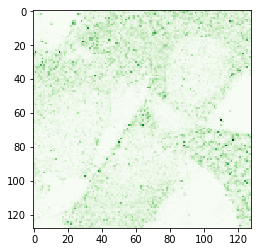

In [27]:
print(output_images.shape)
crop_id = 5
img = output_images[crop_id, 1, :, :]
plt.imshow(img, cmap='Greens')

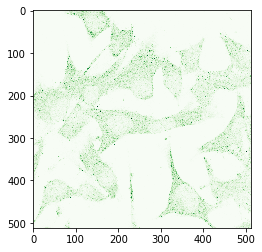

In [19]:
img = color_image[1, :, :]
plt.imshow(img, cmap='Greens')

In [4]:
train_label = pd.read_csv('data/raw/train.csv')

In [15]:
#i = 0
#img_file = 'data/raw/train/%s_red.png'%train_label.Id[i]
#img = plt.imread(img_file)
#plt.imshow(img, cmap='Reds')

In [18]:
def load_image(img_file):
    data = []
    for f in ['data/raw/train/%s_%s.png'%(img_file, color) for color in ['red', 'green', 'blue', 'yellow']]:
        img = plt.imread(f)
        data.append(img)
    return np.array(data)

img_file = train_label.Id[15]
color_image = load_image(img_file)